In [1]:
import os
import re
from collections import defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.utils import resample

import pickle
import joblib

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.utils import to_categorical

from gensim.models import Word2Vec, FastText

import warnings
warnings.filterwarnings('ignore')

In [2]:
root = '/kaggle/input/imdb-grinatom/aclImdb_v1/aclImdb/'

In [3]:
# with open(root+'train/pos/1000_8.txt') as file:
#     review = file.read()
#     print(review)

In [4]:
# def create_csv(data_dir, output_csv):
#     reviews = []
#     ratings = []
#     sentiments = []

#     for sentiment in ['pos', 'neg']:
#         folder_path = os.path.join(data_dir, sentiment)
#         for filename in os.listdir(data_dir):
#             if filename.endswith(".txt"):
#                 rating = int(filename.split('_')[1].split('.')[0])

#                 with open(os.path.join(data_dir, filename), 'r', encoding='utf-8') as file:
#                     review = file.read()

#                 reviews.append(review)
#                 ratings.append(rating)
#                 sentiments.append(sentiment)

#     df = pd.DataFrame({
#         'review': reviews,
#         'rating': ratings,
#         'sentiment': sentiments
#     })

#     df.to_csv(output_csv, index=False)

In [5]:
# train_dir = root + 'train'
# test_dir = root + 'test'

# create_csv(train_dir, 'train.csv')
# create_csv(test_dir, 'test.csv')

In [6]:
# create_csv('/kaggle/input/imdb-grinatom/aclImdb/train/unsup', 'unsup.csv')

In [7]:
train_df = pd.read_csv('/kaggle/input/imdb-grinatom/cleaned_train.csv')
test_df = pd.read_csv('/kaggle/input/imdb-grinatom/cleaned_test.csv')
train_ddf = pd.read_csv('/kaggle/input/imdb-grinatom/train.csv')
test_ddf = pd.read_csv('/kaggle/input/imdb-grinatom/test.csv')

In [8]:
def count_words(text):
    return len(text.split())

train_word_counts = train_df['review'].apply(count_words)
test_word_counts = test_df['review'].apply(count_words)

train_mean_words = train_word_counts.mean()
train_max_words = train_word_counts.max()

test_mean_words = test_word_counts.mean()
test_max_words = test_word_counts.max()

print(f"Train DataFrame:")
print(f"Среднее число слов: {train_mean_words}")
print(f"Максимальное число слов: {train_max_words}")

print(f"Test DataFrame:")
print(f"Среднее число слов: {test_mean_words}")
print(f"Максимальное число слов: {test_max_words}")

Train DataFrame:
Среднее число слов: 105.30524
Максимальное число слов: 1287
Test DataFrame:
Среднее число слов: 102.82496
Максимальное число слов: 1052


In [9]:
all_texts = train_df['review']

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(all_texts)

word_counts = tokenizer.word_counts

def calculate_coverage(word_counts, num_words):
    total_words = sum(word_counts.values())
    top_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:num_words]
    top_words_count = sum(count for word, count in top_words)
    coverage = top_words_count / total_words
    return coverage

coverages = {}
for num_words in [5000, 7500, 10000, 20000, 30000, 40000, 50000]:
    coverage = calculate_coverage(word_counts, num_words)
    coverages[num_words] = coverage
    print(f"Coverage with {num_words} words: {coverage:.2%}")

Coverage with 5000 words: 85.41%
Coverage with 7500 words: 89.85%
Coverage with 10000 words: 92.48%
Coverage with 20000 words: 97.01%
Coverage with 30000 words: 98.53%
Coverage with 40000 words: 99.18%
Coverage with 50000 words: 99.56%


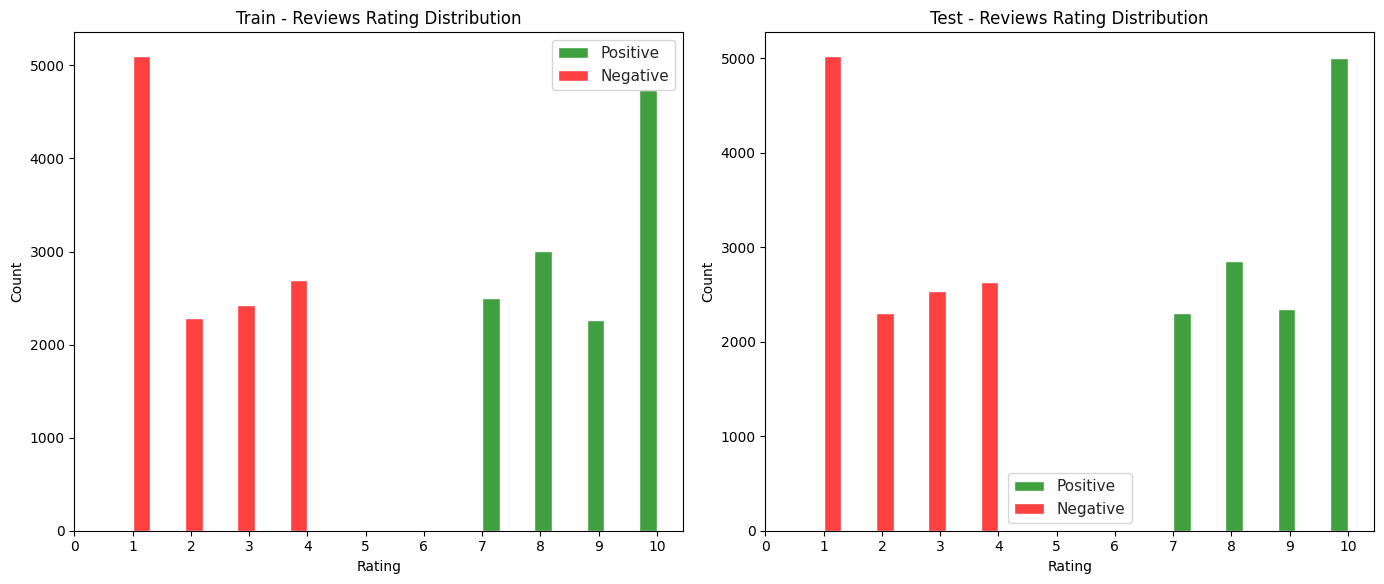

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.set(style="whitegrid")

def plot_histogram(ax, pos_data, neg_data, title):
    sns.histplot(pos_data, bins=10, kde=False, ax=ax, color='green', label='Positive')
    sns.histplot(neg_data, bins=10, kde=False, ax=ax, color='red', label='Negative')
    ax.set_title(title)
    ax.set_xlabel('Rating')
    ax.set_ylabel('Count')
    ax.set_xticks(range(0, 11))
    ax.legend()

plot_histogram(axs[0], train_df[train_df['sentiment'] == 'pos']['rating'], train_df[train_df['sentiment'] == 'neg']['rating'], 'Train - Reviews Rating Distribution')
plot_histogram(axs[1], test_df[test_df['sentiment'] == 'pos']['rating'], test_df[test_df['sentiment'] == 'neg']['rating'], 'Test - Reviews Rating Distribution')

plt.tight_layout()
plt.show()

In [11]:
nlp = spacy.load("en_core_web_sm")

contractions_dict = {
    "aren't": "are not",
    "can't": "can not",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "i'd": "i would",
    "i'll": "i will",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "might've": "might have",
    "must've": "must have",
    "mustn't": "must not",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what's": "what is",
    "where's": "where is",
    "who's": "who is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you've": "you have",
}

def expand_contractions(text, contractions_dict):
    for contraction, expanded in contractions_dict.items():
        text = re.sub(r"\b{}\b".format(contraction), expanded, text)
    return text

def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, ' ', text)

def clean_text(text):
    text = remove_html_tags(text)
    
    text = text.lower()
    
    text = expand_contractions(text, contractions_dict)
    
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    
    doc = nlp(text)
    
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    tokens = [token for token in tokens if len(token) > 1 or token.isdigit()]
    
    clean_text = ' '.join(tokens)
    
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    
    return clean_text

In [12]:
sample_text = """I loved this movie from beginning to end.I am a musician and i let drugs get in the way of my some of the things i used to love(skateboarding,drawing) but my friends were always there for me.Music was like my rehab,life support,and my drug.It changed my life.I can totally relate to this movie and i wish there was more i could say.This movie left me speechless to be honest.I just saw it on the Ifc channel.I usually hate having satellite but this was a perk of having satellite.The ifc channel shows some really great movies and without it I never would have found this movie.Im not a big fan of the international films because i find that a lot of the don't do a very good job on translating lines.I mean the obvious language barrier leaves you to just believe thats what they are saying but its not that big of a deal i guess.I almost never got to see this AMAZING movie.Good thing i stayed up for it instead of going to bed..well earlier than usual.lol.I hope you all enjoy the hell of this movie and Love this movie just as much as i did.I wish i could type this all in caps but its again the rules i guess thats shouting but it would really show my excitement for the film.I Give It Three Thumbs Way Up!<br /><br />This Movie Blew ME AWAY!"""
cleaned_text = clean_text(sample_text)
print(cleaned_text)  

love movie begin end musician let drug way thing love skateboard draw friend music like rehab life support drug change life totally relate movie wish movie leave speechless honest see ifc channel usually hate have satellite perk have satellite ifc channel show great movie find movie big fan international film find lot good job translate line mean obvious language barrier leave believe say big deal guess get amazing movie good thing stay instead go bed early usual lol hope enjoy hell movie love movie wish type cap rule guess shout excitement film thumb way movie blow away


In [13]:
# train_df['review'] = train_df['review'].apply(clean_text)
# test_df['review'] = test_df['review'].apply(clean_text)

In [14]:
# train_df.to_csv('cleaned_train.csv', index=False)
# test_df.to_csv('cleaned_test.csv', index=False)

# classic

In [15]:
# cleaned_train_df = pd.read_csv('/kaggle/working/cleaned_train.csv')
# cleaned_test_df = pd.read_csv('/kaggle/working/cleaned_test.csv')

In [16]:
all_data = pd.concat([train_df, test_df])

In [17]:
vectorizer = CountVectorizer(max_features=20000)
X = vectorizer.fit_transform(all_data['review'])

In [18]:
X_train = X[:len(train_df)]
X_test = X[len(train_df):]

y_train = train_df['rating']
y_test = test_df['rating']

In [19]:
min_samples = y_train.value_counts().min()

def undersample(df, target_column, min_samples):
    undersampled_dfs = []
    for rating in df[target_column].unique():
        rating_df = df[df[target_column] == rating]
        undersampled_df = resample(rating_df, replace=False, n_samples=min_samples, random_state=42)
        undersampled_dfs.append(undersampled_df)
    return pd.concat(undersampled_dfs)

undersampled_train_df = undersample(train_df, 'rating', min_samples)

X_train_undersampled = vectorizer.transform(undersampled_train_df['review'])
y_train_undersampled = undersampled_train_df['rating']

undersampled_test_df = undersample(test_df, 'rating', min_samples)

X_test_undersampled = vectorizer.transform(undersampled_test_df['review'])
y_test_undersampled = undersampled_test_df['rating']

In [20]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, C=1.0, solver='saga', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'Support Vector Machine': SVC(C=1.0, kernel='linear', random_state=42)
}

In [21]:
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, save_dir=None):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:,.3f}")

        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("\n")

        model_path = os.path.join(save_dir, f"{name.replace(' ', '_')}.joblib")
        joblib.dump(model, model_path)
        print(f"Model {name} saved to {model_path}\n")

In [22]:
tfidf = TfidfVectorizer(max_features=20000)

X_train_tfidf = tfidf.fit_transform(train_df['review'])
X_test_tfidf = tfidf.transform(test_df['review'])  

with open('tfidf.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

In [23]:
train_and_evaluate_models(models, X_train, y_train, X_test, y_test, 'default_mc8_data')

Training Logistic Regression...
Accuracy: 0.359
Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.63      0.59      5022
           2       0.18      0.15      0.17      2302
           3       0.22      0.19      0.20      2541
           4       0.25      0.26      0.26      2635
           7       0.24      0.22      0.23      2307
           8       0.23      0.21      0.22      2850
           9       0.20      0.16      0.18      2344
          10       0.50      0.56      0.53      4999

    accuracy                           0.36     25000
   macro avg       0.29      0.30      0.29     25000
weighted avg       0.34      0.36      0.35     25000



Model Logistic Regression saved to default_mc8_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.353
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.94      0.49      5022
           2       0.0

In [24]:
train_and_evaluate_models(models, X_train_undersampled, y_train_undersampled, X_test_undersampled, y_test_undersampled, 'undersampled_mc8_data')

Training Logistic Regression...
Accuracy: 0.290
Classification Report:
              precision    recall  f1-score   support

           1       0.43      0.47      0.45      2263
           2       0.25      0.25      0.25      2263
           3       0.24      0.22      0.23      2263
           4       0.26      0.27      0.26      2263
           7       0.28      0.24      0.26      2263
           8       0.23      0.22      0.22      2263
           9       0.25      0.26      0.26      2263
          10       0.36      0.39      0.38      2263

    accuracy                           0.29     18104
   macro avg       0.29      0.29      0.29     18104
weighted avg       0.29      0.29      0.29     18104



Model Logistic Regression saved to undersampled_mc8_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.283
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.64      0.45      2263
           2     

In [25]:
train_and_evaluate_models(models, X_train_tfidf, y_train, X_test_tfidf, y_test, 'tfidf_mc8_data')

Training Logistic Regression...
Accuracy: 0.411
Classification Report:
              precision    recall  f1-score   support

           1       0.51      0.81      0.63      5022
           2       0.19      0.06      0.09      2302
           3       0.25      0.12      0.16      2541
           4       0.30      0.31      0.30      2635
           7       0.30      0.21      0.25      2307
           8       0.25      0.21      0.23      2850
           9       0.22      0.05      0.09      2344
          10       0.47      0.75      0.58      4999

    accuracy                           0.41     25000
   macro avg       0.31      0.31      0.29     25000
weighted avg       0.35      0.41      0.36     25000



Model Logistic Regression saved to tfidf_mc8_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.350
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.93      0.50      5022
           2       0.00 

# classic pos/neg

In [26]:
neg_train_df = train_df[train_df['rating'].between(1, 4)]
neg_test_df = test_df[test_df['rating'].between(1, 4)]
pos_train_df = train_df[train_df['rating'].between(7, 10)]
pos_test_df = test_df[test_df['rating'].between(7, 10)]

X_train_neg = vectorizer.transform(neg_train_df['review'])
X_test_neg = vectorizer.transform(neg_test_df['review'])
X_train_pos = vectorizer.transform(pos_train_df['review'])
X_test_pos = vectorizer.transform(pos_test_df['review'])

y_train_neg = neg_train_df['rating']
y_test_neg = neg_test_df['rating']
y_train_pos = pos_train_df['rating']
y_test_pos = pos_test_df['rating']

print("Negative reviews (1-4):")
train_and_evaluate_models(models, X_train_neg, y_train_neg, X_test_neg, y_test_neg, 'bow_mc4_neg_data')

print("Positive reviews (7-10):")
train_and_evaluate_models(models, X_train_pos, y_train_pos, X_test_pos, y_test_pos, 'bow_mc4_pos_data')

Negative reviews (1-4):
Training Logistic Regression...
Accuracy: 0.419
Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.64      0.61      5022
           2       0.21      0.19      0.20      2302
           3       0.27      0.23      0.25      2541
           4       0.38      0.37      0.37      2635

    accuracy                           0.42     12500
   macro avg       0.36      0.36      0.36     12500
weighted avg       0.40      0.42      0.41     12500



Model Logistic Regression saved to bow_mc4_neg_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.403
Classification Report:
              precision    recall  f1-score   support

           1       0.40      1.00      0.57      5022
           2       0.00      0.00      0.00      2302
           3       1.00      0.00      0.00      2541
           4       0.59      0.00      0.01      2635

    accuracy                           0.40     125

In [27]:
min_samples_neg = min(neg_train_df['rating'].value_counts().min(), neg_test_df['rating'].value_counts().min())
min_samples_pos = min(pos_train_df['rating'].value_counts().min(), pos_test_df['rating'].value_counts().min())

undersampled_neg_train_df = undersample(neg_train_df, 'rating', min_samples_neg)
undersampled_neg_test_df = undersample(neg_test_df, 'rating', min_samples_neg)
undersampled_pos_train_df = undersample(pos_train_df, 'rating', min_samples_pos)
undersampled_pos_test_df = undersample(pos_test_df, 'rating', min_samples_pos)

X_train_neg_undersampled = vectorizer.transform(undersampled_neg_train_df['review'])
X_test_neg_undersampled = vectorizer.transform(undersampled_neg_test_df['review'])
X_train_pos_undersampled = vectorizer.transform(undersampled_pos_train_df['review'])
X_test_pos_undersampled = vectorizer.transform(undersampled_pos_test_df['review'])

y_train_neg_undersampled = undersampled_neg_train_df['rating']
y_test_neg_undersampled = undersampled_neg_test_df['rating']
y_train_pos_undersampled = undersampled_pos_train_df['rating']
y_test_pos_undersampled = undersampled_pos_test_df['rating']

print("Undersampled negative reviews (1-4):")
train_and_evaluate_models(models, X_train_neg_undersampled, y_train_neg_undersampled, X_test_neg_undersampled, y_test_neg_undersampled, 'bow_undersampled_mc4_neg_data')

print("Undersampled positive reviews (7-10):")
train_and_evaluate_models(models, X_train_pos_undersampled, y_train_pos_undersampled, X_test_pos_undersampled, y_test_pos_undersampled, 'bow_undersampled_mc4_pos_data')

Undersampled negative reviews (1-4):
Training Logistic Regression...
Accuracy: 0.360
Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.49      0.48      2284
           2       0.28      0.28      0.28      2284
           3       0.29      0.27      0.28      2284
           4       0.39      0.40      0.39      2284

    accuracy                           0.36      9136
   macro avg       0.36      0.36      0.36      9136
weighted avg       0.36      0.36      0.36      9136



Model Logistic Regression saved to bow_undersampled_mc4_neg_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.363
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.67      0.50      2284
           2       0.28      0.15      0.20      2284
           3       0.30      0.21      0.25      2284
           4       0.38      0.43      0.40      2284

    accuracy             

In [28]:
tfidf = TfidfVectorizer(max_features=20000, stop_words='english')

X_train_neg_tfidf = tfidf.fit_transform(neg_train_df['review'])
X_test_neg_tfidf = tfidf.transform(neg_test_df['review'])
X_train_pos_tfidf = tfidf.transform(pos_train_df['review'])
X_test_pos_tfidf = tfidf.transform(pos_test_df['review'])

with open('tfidf_dd.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("TF-IDF negative reviews (1-4):")
train_and_evaluate_models(models, X_train_neg_tfidf, y_train_neg, X_test_neg_tfidf, y_test_neg, 'tfidf_mc4_neg_data')

print("TF-IDF positive reviews (7-10):")
train_and_evaluate_models(models, X_train_pos_tfidf, y_train_pos, X_test_pos_tfidf, y_test_pos, 'tfidf_mc4_pos_data')

TF-IDF negative reviews (1-4):
Training Logistic Regression...
Accuracy: 0.480
Classification Report:
              precision    recall  f1-score   support

           1       0.55      0.84      0.67      5022
           2       0.21      0.06      0.10      2302
           3       0.30      0.15      0.20      2541
           4       0.43      0.48      0.45      2635

    accuracy                           0.48     12500
   macro avg       0.37      0.38      0.35     12500
weighted avg       0.41      0.48      0.42     12500



Model Logistic Regression saved to tfidf_mc4_neg_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.402
Classification Report:
              precision    recall  f1-score   support

           1       0.40      1.00      0.57      5022
           2       0.00      0.00      0.00      2302
           3       1.00      0.00      0.00      2541
           4       0.29      0.00      0.00      2635

    accuracy                           0.4

In [29]:
tfidf = TfidfVectorizer(max_features=20000, stop_words='english')

X_train_neg_tfidf_undersampled = tfidf.fit_transform(undersampled_neg_train_df['review'])
X_test_neg_tfidf_undersampled = tfidf.transform(undersampled_neg_test_df['review'])
X_train_pos_tfidf_undersampled = tfidf.transform(undersampled_pos_train_df['review'])
X_test_pos_tfidf_undersampled = tfidf.transform(undersampled_pos_test_df['review'])

with open('tfidf_ud.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

y_train_neg_tfidf_undersampled = undersampled_neg_train_df['rating']
y_test_neg_tfidf_undersampled = undersampled_neg_test_df['rating']
y_train_pos_tfidf_undersampled = undersampled_pos_train_df['rating']
y_test_pos_tfidf_undersampled = undersampled_pos_test_df['rating']

print("Undersampled TF-IDF negative reviews (1-4):")
train_and_evaluate_models(models, X_train_neg_tfidf_undersampled, y_train_neg_tfidf_undersampled, X_test_neg_tfidf_undersampled, y_test_neg_tfidf_undersampled, 'utfidf_mc4_neg_data')

print("Undersampled TF-IDF positive reviews (7-10):")
train_and_evaluate_models(models, X_train_pos_tfidf_undersampled, y_train_pos_tfidf_undersampled, X_test_pos_tfidf_undersampled, y_test_pos_tfidf_undersampled, 'utfidf_mc4_pos_data')

Undersampled TF-IDF negative reviews (1-4):
Training Logistic Regression...
Accuracy: 0.387
Classification Report:
              precision    recall  f1-score   support

           1       0.49      0.54      0.52      2284
           2       0.30      0.25      0.27      2284
           3       0.30      0.27      0.28      2284
           4       0.41      0.49      0.45      2284

    accuracy                           0.39      9136
   macro avg       0.38      0.39      0.38      9136
weighted avg       0.38      0.39      0.38      9136



Model Logistic Regression saved to utfidf_mc4_neg_data/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.357
Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.62      0.49      2284
           2       0.27      0.15      0.19      2284
           3       0.29      0.21      0.24      2284
           4       0.38      0.45      0.41      2284

    accuracy                

# word embeddings

In [30]:
sentences = [text.split() for text in train_df['review']]

In [31]:
X_train = train_df['review']
X_test = train_df['review']

y_train = train_df['rating']
y_test = test_df['rating']

In [32]:
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in model.wv:
            n_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

In [33]:
def average_glove_vectors(words, embeddings_index, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    n_words = 0
    for word in words:
        if word in embeddings_index:
            n_words += 1
            feature_vector = np.add(feature_vector, embeddings_index[word])
    if n_words > 0:
        feature_vector = np.divide(feature_vector, n_words)
    return feature_vector

In [34]:
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)
X_train_word2vec = np.array([average_word_vectors(text.split(), word2vec_model, 100) for text in X_train])
X_test_word2vec = np.array([average_word_vectors(text.split(), word2vec_model, 100) for text in X_test])

In [35]:
glove_path = '/kaggle/input/imdb-grinatom/glove.twitter.27B.100d.txt'
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector

X_train_glove = np.array([average_glove_vectors(text.split(), embeddings_index, 100) for text in X_train])
X_test_glove = np.array([average_glove_vectors(text.split(), embeddings_index, 100) for text in X_test])

In [36]:
fasttext_model = FastText(sentences, vector_size=100, window=5, min_count=5, workers=4)
X_train_fasttext = np.array([average_word_vectors(text.split(), fasttext_model, 100) for text in X_train])
X_test_fasttext = np.array([average_word_vectors(text.split(), fasttext_model, 100) for text in X_test])

In [37]:
train_and_evaluate_models(models, X_train_word2vec, y_train, X_test_word2vec, y_test, 'w2v')

Training Logistic Regression...
Accuracy: 0.280
Classification Report:
              precision    recall  f1-score   support

           1       0.35      0.59      0.44      5022
           2       0.10      0.01      0.02      2302
           3       0.15      0.04      0.07      2541
           4       0.14      0.16      0.15      2635
           7       0.13      0.10      0.11      2307
           8       0.19      0.17      0.18      2850
           9       0.16      0.01      0.01      2344
          10       0.34      0.55      0.42      4999

    accuracy                           0.28     25000
   macro avg       0.19      0.20      0.17     25000
weighted avg       0.23      0.28      0.23     25000



Model Logistic Regression saved to w2v/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.290
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.65      0.44      5022
           2       0.21      0.02  

In [38]:
train_and_evaluate_models(models, X_train_glove, y_train, X_test_glove, y_test, 'glove')

Training Logistic Regression...
Accuracy: 0.285
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.63      0.44      5022
           2       0.14      0.01      0.01      2302
           3       0.16      0.04      0.06      2541
           4       0.14      0.13      0.13      2635
           7       0.13      0.09      0.10      2307
           8       0.19      0.17      0.18      2850
           9       0.15      0.01      0.02      2344
          10       0.33      0.56      0.42      4999

    accuracy                           0.28     25000
   macro avg       0.20      0.20      0.17     25000
weighted avg       0.23      0.28      0.23     25000



Model Logistic Regression saved to glove/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.301
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.70      0.45      5022
           2       0.24      0.02

In [39]:
train_and_evaluate_models(models, X_train_fasttext, y_train, X_test_fasttext, y_test, 'ft')

Training Logistic Regression...
Accuracy: 0.277
Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.59      0.43      5022
           2       0.14      0.01      0.02      2302
           3       0.14      0.04      0.06      2541
           4       0.14      0.14      0.14      2635
           7       0.13      0.10      0.12      2307
           8       0.18      0.15      0.16      2850
           9       0.15      0.01      0.01      2344
          10       0.33      0.56      0.42      4999

    accuracy                           0.28     25000
   macro avg       0.19      0.20      0.17     25000
weighted avg       0.22      0.28      0.22     25000



Model Logistic Regression saved to ft/Logistic_Regression.joblib

Training Random Forest...
Accuracy: 0.288
Classification Report:
              precision    recall  f1-score   support

           1       0.33      0.65      0.44      5022
           2       0.21      0.03   

# binary lstm/gru

In [40]:
X_train = train_df['review']
X_test = train_df['review']

y_train = train_df['sentiment']
y_test = test_df['sentiment']

In [41]:
# min_samples = y_train.value_counts().min()

# def undersample(df, target_column, min_samples):
#     undersampled_dfs = []
#     for rating in df[target_column].unique():
#         rating_df = df[df[target_column] == rating]
#         undersampled_df = resample(rating_df, replace=False, n_samples=min_samples, random_state=42)
#         undersampled_dfs.append(undersampled_df)
#     return pd.concat(undersampled_dfs)

# undersampled_train_df = undersample(train_df, 'rating', min_samples)

# X_train_undersampled = undersampled_train_df['review']
# y_train_undersampled = undersampled_train_df['rating']

# undersampled_test_df = undersample(test_df, 'rating', min_samples)

# X_test_undersampled = undersampled_test_df['review']
# y_test_undersampled = undersampled_test_df['rating']

In [42]:
tokenizer = Tokenizer(num_words=20000, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [43]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
max_length = 128
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [45]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [46]:
def create_lstm_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
    return model

In [47]:
def create_gru_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
    return model

In [48]:
def train_and_evaluate_binary_models(models, X_train, y_train, X_test, y_test, epochs=1, batch_size=64, save_dir=None):
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for name, model_fn in models.items():
        print(f"Training {name}...")

        model = model_fn()

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

        loss, accuracy, mse = model.evaluate(X_test, y_test)
        print(f"{name} Test Accuracy: {accuracy:.3f}")
        print(f"{name} Test MSE: {mse:.3f}")

        y_pred = model.predict(X_test)
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()
        print("Classification Report:")
        print(classification_report(y_test, y_pred_classes))
        
        if save_dir:
            model_path = os.path.join(save_dir, f'{name}_model.h5')
            model.save(model_path)
            print(f"{name} saved to {model_path}\n")

In [49]:
vocab_size = 20000
embedding_dim = 100

models = {
    'LSTM': lambda: create_lstm_model(vocab_size, embedding_dim, max_length),
    'GRU': lambda: create_gru_model(vocab_size, embedding_dim, max_length)
}

In [50]:
train_and_evaluate_binary_models(models, X_train_padded, y_train_encoded, X_test_padded, y_test_encoded, epochs=5, batch_size=4, save_dir='binary_models')

Training LSTM...
Epoch 1/5
6250/6250 - 64s - 10ms/step - accuracy: 0.5579 - loss: 0.6709 - mse: 0.2393 - val_accuracy: 0.7170 - val_loss: 0.5387 - val_mse: 0.1795
Epoch 2/5
6250/6250 - 59s - 9ms/step - accuracy: 0.8494 - loss: 0.3692 - mse: 0.1129 - val_accuracy: 0.9201 - val_loss: 0.2185 - val_mse: 0.0609
Epoch 3/5
6250/6250 - 59s - 9ms/step - accuracy: 0.9142 - loss: 0.2261 - mse: 0.0645 - val_accuracy: 0.9616 - val_loss: 0.1324 - val_mse: 0.0326
Epoch 4/5
6250/6250 - 59s - 9ms/step - accuracy: 0.9512 - loss: 0.1395 - mse: 0.0375 - val_accuracy: 0.9815 - val_loss: 0.0776 - val_mse: 0.0168
Epoch 5/5
6250/6250 - 59s - 9ms/step - accuracy: 0.9773 - loss: 0.0757 - mse: 0.0187 - val_accuracy: 0.9909 - val_loss: 0.0327 - val_mse: 0.0075
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9894 - loss: 0.0344 - mse: 0.0083
LSTM Test Accuracy: 0.991
LSTM Test MSE: 0.008
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Classification Report:
              precision    recall  f1-score   support

  

# regression lstm/gru

In [51]:
def create_lstm_mc_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
    return model

In [52]:
def create_gru_mc_model(vocab_size, embedding_dim, max_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(GRU(32, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'mse'])
    return model

In [53]:
def prepare_labels(ratings):
    classes = []
    for rating in ratings:
        if rating in [1, 2, 3, 4]:
            classes.append(rating - 1)
        elif rating in [7, 8, 9, 10]:
            classes.append(rating - 7)
    return to_categorical(classes, num_classes=4)

In [54]:
def tokenize_and_pad(X_train, X_test, num_words=20000, max_length=128):
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')
    
    return X_train_padded, X_test_padded, tokenizer

In [55]:
y_train_neg = prepare_labels(train_df[train_df['rating'].between(1, 4)]['rating'])
y_train_pos = prepare_labels(train_df[train_df['rating'].between(7, 10)]['rating'])

y_test_neg = prepare_labels(test_df[test_df['rating'].between(1, 4)]['rating'])
y_test_pos = prepare_labels(test_df[test_df['rating'].between(7, 10)]['rating'])

In [56]:
X_train_neg = train_df[train_df['rating'].between(1, 4)]['review']
X_test_neg = test_df[test_df['rating'].between(1, 4)]['review']
X_train_pos = train_df[train_df['rating'].between(7, 10)]['review']
X_test_pos = test_df[test_df['rating'].between(7, 10)]['review']

In [57]:
X_train_neg_padded, X_test_neg_padded, neg_tokenizer = tokenize_and_pad(X_train_neg, X_test_neg)

X_train_pos_padded, X_test_pos_padded, pos_tokenizer = tokenize_and_pad(X_train_pos, X_test_pos)

In [58]:
models = {
    'LSTM': lambda: create_lstm_mc_model(vocab_size, embedding_dim, max_length),
    'GRU': lambda: create_gru_mc_model(vocab_size, embedding_dim, max_length)
}

In [59]:
def train_and_evaluate_mc_models(models, X_train, y_train, X_test, y_test, epochs=1, batch_size=64, save_dir=None):
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    for name, model_fn in models.items():
        print(f"Training {name}...")

        model = model_fn()

        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=2)

        loss, accuracy, mse = model.evaluate(X_test, y_test)
        print(f"{name} Test Accuracy: {accuracy:.3f}")
        print(f"{name} Test MSE: {mse:.3f}")

        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_test, axis=1)

        print("Classification Report:")
        print(classification_report(y_true_classes, y_pred_classes))

        if save_dir:
            model_path = os.path.join(save_dir, f'{name}_model.h5')
            model.save(model_path)
            print(f"{name} saved to {model_path}\n")

In [60]:
train_and_evaluate_mc_models(models, X_train_neg_padded, y_train_neg, X_test_neg_padded, y_test_neg, epochs=5, batch_size=4, save_dir='binary_neg_models')

train_and_evaluate_mc_models(models, X_train_pos_padded, y_train_pos, X_test_pos_padded, y_test_pos, epochs=5, batch_size=4, save_dir='binary_pos_models')

Training LSTM...
Epoch 1/5
3125/3125 - 33s - 10ms/step - accuracy: 0.4084 - loss: 1.3224 - mse: 0.1786 - val_accuracy: 0.4089 - val_loss: 1.3213 - val_mse: 0.1784
Epoch 2/5
3125/3125 - 31s - 10ms/step - accuracy: 0.4580 - loss: 1.2614 - mse: 0.1702 - val_accuracy: 0.4034 - val_loss: 1.3687 - val_mse: 0.1837
Epoch 3/5
3125/3125 - 31s - 10ms/step - accuracy: 0.5224 - loss: 1.1173 - mse: 0.1508 - val_accuracy: 0.4154 - val_loss: 1.3893 - val_mse: 0.1810
Epoch 4/5
3125/3125 - 31s - 10ms/step - accuracy: 0.5926 - loss: 0.9453 - mse: 0.1259 - val_accuracy: 0.4431 - val_loss: 1.4597 - val_mse: 0.1816
Epoch 5/5
3125/3125 - 31s - 10ms/step - accuracy: 0.6736 - loss: 0.7596 - mse: 0.1013 - val_accuracy: 0.4320 - val_loss: 1.6511 - val_mse: 0.1915
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4297 - loss: 1.6433 - mse: 0.1905
LSTM Test Accuracy: 0.432
LSTM Test MSE: 0.192
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support